
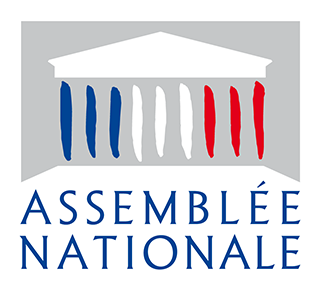

## RAMP on french deputies votes prediction

Team members: *Florian Eisenbarth, Nicolas Oulianov, Nicolas Boussenina, Armand Foucault, Eloi Alardet*


## Introduction

This group project is about predicting positions of deputies on votes in the French National Assembly. 

### Context

#### The National Assembly

The National Assembly is the French lower house of the parliament, the higher house being the Senate. The Assembly is composed of deputies elected every five years during legislatives elections. One deputy represents one electoral district, composed of 63 000 to 150 000 inhabitants. In total, there are **577 seats available** for the deputies in the Assembly. 

Most of the times, deputies campaign in their district under the banner of a political party. But once elected, inside the Assembly, deputies join or create **parliamentary groups** of at least 15 deputies, that are not exactly the same as political parties. 

These groups are used for various reasons.

- Small parties can regroup their voting forces.
- Likely-minded deputies that are not in the same political parties can work together inside the same group.
- You get various advantages: more time to talk at the Assembly and one representative at the President's conference (a weekly reunion of all the parliamentary groups presidents).

Some groups corresponds to exactly one party. For example, the group "En marche" or the group "Les Républicains". 

If a deputy does not belong to any parliamentary groups, he is part of the **‘non inscrit’** group, which is not a parliamentary group strictly speaking.

A deputy can also be a member of a **parliamentary commission**, which are specialized groups that review the laws for a specific subject (finance, security, health…). 


#### What do we vote ?

In the French legislative system, the government and deputies can propose laws. Before a law is adopted, the text is called a: 

+ **project of law**, when it is proposed by the government
+ **proposition of law**, when it is proposed by a parliament member

Please note that we are using literal French terminology as we are not legalists. 

All members of the parliament, commissions and the government can propose **amendments** which are modifications about parts or articles of the discussed text of law. It is basically a rewrite of one particular aspect of the text of law. There also exists **sub-amendments**, which are basically amendments of an amendment.


All text of laws and amendments are voted by absolute majority, where one deputy equals one vote. Not every deputy, however, is required to vote. 

### Objective

Citizens scrutinize the deputies they voted for with great interest. A concern is that deputies don't vote thinking about the vote topic itself, but only with partisanship reasoning: they vote for an allied political group, and against an ennemy political group. These "friendship rules" undermine Democracy and are disapproved by citizens. 


Our goal is to study to which extent political groups' votes in the Assembly are reducible to those "friendship rules", and are thus predictible. 

To do so, we use open data provided by the French Government about votes in Assembly. To simplify the problem, we predict votes not by deputy but by parliamentary groups. Precisely, we try to predict the majority position of a parliamentary group on a vote topic: for, against, abstention, non-presence.  

For performance purposes, we will reduce the number of positions to two (**for** or **not for**, which encompass against, absention, etc.). We will also not consider every parliamentary group for prediction, but only the largest ones. 

In other terms, **our project is a [Multilabel classification task](https://scikit-learn.org/stable/modules/multiclass.html) to predict if a set of parliamentary group vote for a given vote, or not.**

The metric used for evaluation is a weighted F1-score: several F1-scores are computed for each class (parliamentary group), and then averaged, using the share of deputies in Assembly for this parliamentary group as weights. 

### Data

All the data we use in this project comes from government's [open data, freely available on the National Assembly website](https://data.assemblee-nationale.fr/).

This data is very large, as everything ever said or proposed is recorded, and not in the format we want. We will describe below the processing we performed. 

#### Processing

1. We gather the various stacks of individual .csv files into aggregate ones with only relevant information. We create aggregate .csv :
    - one .csv with all the **actors**, which is another name for deputies and scenators. 
    - one .csv with all information about **votes** : topic, date...
    - one .csv with the **results of votes** 
2. We filter these aggregate .csv to keep only relevant information. We keep only data relevant to the latest election. In otherwords, we select data in the timeframe between July, 4th 2017 and November, 20th 2020. 
3. We format this data in a "prediction-ready" format, with a features DataFrame X and a target DataFrame y. 

#### Description

Here are the **features** we made available for the problem:
+ **vote_uid (str)**: the id of the vote
+ **date (str)**: date of the vote
+ **libelle (str)**: short description of the topic of the vote
+ **code_type_vote (str)**: code of the type of the vote
+ **libelle_type_vote (str)**: same as code_type_vote but more explicit
+ **demandeur (str)** : the deputy or group which has asked for this vote
+ **presence_per_party (dic)**: number of deputies physically present for the vote by group
+ **nb_votants (int)**: total number of deputies who actually voted
 
Our **target** corresponds to the results of the vote. 
- There are 10 columns, one for each parliamentary group considered. 
- Each line corresponds to a vote. The index is the vote_id. 
- The values are 1 if the group voted for, 0 if the group did something else (*against, abstention, non-presence*) 

We also provided another .csv file with information about political parties and their members : birth date, sex, twitter... This .csv can be used for further feature engineering. 

#### Train-test split

The train-test split is made temporally. First 80% of votes are in the train dataset, last 20% of votes are in the test dataset. This is because votes are temporally bounded and, ultimately, we want to predict future political decisions.

### Data Exploration

To better understand the problem, let's drill down in the data.

In [1]:
from problem import get_test_data, get_actor_party_data
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

X, y = get_test_data() # TODO: append X_train and X_test
actors = get_actor_party_data()

In [2]:
# X the features vectors with info about votes

X.head(5)

,code_type_vote,libelle_type_vote,demandeur,libelle,nb_votants,date,presence_per_party,vote_uid
VTANR5L15V2597,SPO,scrutin public ordinaire,"Président du groupe ""de la Gauche démocrate et...",l'amendement n° 458 de Mme Dubié et à l' amend...,119,2020-02-23,"{'SOC': 3, 'FI': 3, 'Dem': 18, 'LT': 3, 'GDR':...",VTANR5L15V2597
VTANR5L15V2598,SPO,scrutin public ordinaire,"Président du groupe ""de la Gauche démocrate et...",l'amendement n° 26856 de Mme Faucillon et les ...,119,2020-02-23,"{'SOC': 3, 'FI': 2, 'Dem': 18, 'LT': 3, 'GDR':...",VTANR5L15V2598
VTANR5L15V2599,SPO,scrutin public ordinaire,"Président du groupe ""La France insoumise""",le sous-amendement n° 42345 de Mme Panot à l'a...,97,2020-02-23,"{'SOC': 1, 'FI': 2, 'Dem': 10, 'LT': 2, 'GDR':...",VTANR5L15V2599
VTANR5L15V2600,SPO,scrutin public ordinaire,"Président du groupe ""La France insoumise""",l'amendement n° 24631 de Mme Bagarry à l'artic...,99,2020-02-23,"{'SOC': 1, 'FI': 3, 'Dem': 11, 'LT': 2, 'GDR':...",VTANR5L15V2600
VTANR5L15V2601,SPO,scrutin public ordinaire,"Président du groupe ""de la Gauche démocrate et...",l'amendement n° 27314 de Mme Bello et les amen...,103,2020-02-23,"{'SOC': 2, 'FI': 3, 'Dem': 13, 'LT': 2, 'GDR':...",VTANR5L15V2601


In [3]:
X['libelle'].iloc[10] # Example of the libelle of a vote

"l'amendement n° 26722 de M. Jumel et les amendements identiques suivants à l'article premier du projet de loi instituant un système universel de retraite (première lecture)."

In [4]:
# y the mutlilabel target vector
y.head(5)

,SOC,FI,Dem,LT,GDR,LaREM,Agir ens,UDI-I,LR,NI
VTANR5L15V2597,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
VTANR5L15V2598,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
VTANR5L15V2599,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
VTANR5L15V2600,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
VTANR5L15V2601,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0


In [5]:
# actors is data to be used for feature engineering

actors.head(8)

,Unnamed: 0,membre_acteurRef,membre_civ,membre_prenom,membre_nom,slug,custom_id,membre_fullname,membre_birthDate,membre_sex,membre_parti
0,0,PA719108,M.,Raphaël,Gérard,raphael gerard,313,Raphaël Gérard,1968-10-17,H,La République en Marche
1,0,PA719044,Mme,Nadia,Essayan,nadia essayan,427,Nadia Essayan,1957-06-06,F,Mouvement Démocrate
2,0,PA672,M.,Jean-Jacques,Bridey,jean-jacques bridey,527,Jean-Jacques Bridey,1953-05-07,H,La République en Marche
3,0,PA719294,Mme,Mireille,Clapot,mireille clapot,571,Mireille Clapot,1963-10-14,F,La République en Marche
4,0,PA719890,Mme,Danielle,Brulebois,danielle brulebois,184,Danielle Brulebois,1947-07-04,F,La République en Marche
5,0,PA721210,M.,Alexis,Corbière,alexis corbiere,397,Alexis Corbière,1968-08-17,H,La France Insoumise
6,0,PA720124,Mme,Aude,Amadou,aude amadou,499,Aude Amadou,1980-02-29,F,La République en Marche
7,0,PA2952,M.,Jean-Luc,Warsmann,jean-luc warsmann,497,Jean-Luc Warsmann,1965-10-22,H,Non déclaré(s)


#### Exploring deputies data

Let's get a sense of scale of the different political party in the French National Assembly. In 2017, the French voted massively for Macron's "La République E Marche" and the "Mouvement démocrate". Notice how some parties only have 1 deputie: this is especially the case for oversea parties.

In [6]:
effectif_table = actors[["membre_acteurRef", 'membre_parti']].groupby("membre_parti").count().reset_index().rename({"membre_parti": "parti", "membre_acteurRef": "parti_nb_membres"}, axis=1).set_index('parti').sort_values('parti_nb_membres', ascending=False)
effectif_table

,parti_nb_membres
parti,
La République en Marche,287
Les Républicains,91
Mouvement Démocrate,53
Parti socialiste,22
"Union des démocrates, radicaux et libéraux",20
La France Insoumise,17
Parti communiste français,15
Régions et peuples solidaires,9
Rassemblement national,5


Let's plot the average age and the share of women in each party.

Text(0, 0.5, 'Mean age')

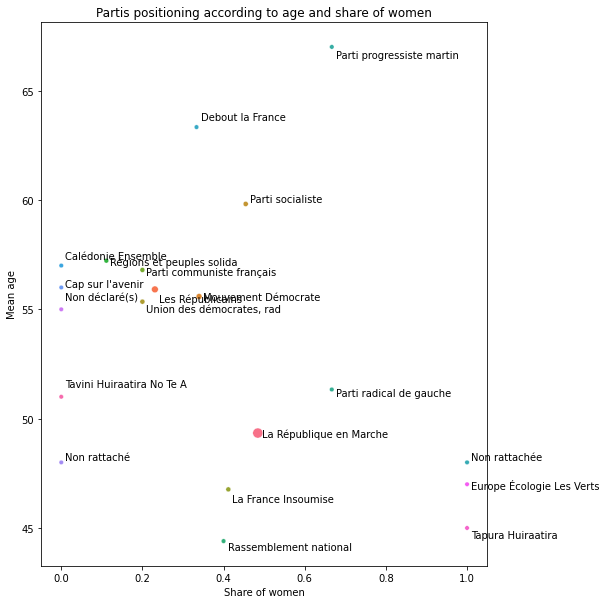

In [7]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

def yearsago(years, from_date=None):
    if from_date is None:
        from_date = datetime.now()
    return from_date - relativedelta(years=years)

def num_years(begin, end=None):
    if end is None:
        end = datetime.now()
    num_years = int((end - begin).days / 365.25)
    if begin > yearsago(num_years, end):
        return num_years - 1
    else:
        return num_years

# Count the number of actors of each sex in each party
parite_table = pd.pivot_table(actors, values="membre_acteurRef", columns="membre_sex", index="membre_parti", aggfunc='count', fill_value=0).reset_index().rename({"membre_parti": "parti"}, axis=1).set_index('parti')
# Compute the share of women of each party
parite_table["parti_share_women"] = parite_table["F"] / (parite_table["F"] + parite_table["H"])
parite_table.drop(["F", "H"], axis=1, inplace=True)

# Compute age of actors
actors['membre_birthDate'] = pd.to_datetime(actors['membre_birthDate'])
actors["membre_age"] = actors["membre_birthDate"].apply(num_years)
# Compute the average age of actors of each party
age_table = actors[["membre_acteurRef", 'membre_parti', "membre_age"]].groupby("membre_parti").mean().reset_index().rename({"membre_parti": "parti", "membre_age": "parti_mean_age"}, axis=1).set_index('parti')

# Group these features together and display them
parti_features = effectif_table.join(parite_table).join(age_table)

# Plot
plt.figure(figsize=(8,10))
p1 = sns.scatterplot(x='parti_share_women', y='parti_mean_age', data=parti_features.reset_index(), size = "parti_nb_membres", hue="parti", legend=False, sizes=(20,100))  

for line in range(0, parti_features.shape[0]):
    # Jitter the text a bit to avoid text clusters
     p1.text(parti_features['parti_share_women'][line]+0.01, parti_features['parti_mean_age'][line] + 1.2*(0.5 - np.random.random()), 
     parti_features.reset_index()['parti'][line][:25], horizontalalignment='left', 
     size='medium', color='black', weight='light')

plt.title('Partis positioning according to age and share of women')
plt.xlabel('Share of women')
plt.ylabel('Mean age')

For the share of women, "Les Républicains" are way behind the other big parties by having only 25% of women, when "La République En Marche", "Parti socialiste" and "La France Insoumise" have roughly 50% of women. Parties with 100% of women have only 1 member. 

Regarding the age of the big parties, "Mouvement démocrate", "Parti socialiste" and "Les Républicains" are the oldest in the assembly. This is the traditional "left vs center vs right" paradigma. On the countrary, "La République En Marche" and "Front National", the two parties that dueled in the Presidential election last round, are younger. This corresponds to new "liberals vs nationalists" paradigma.

#### Exploring votes position repartition

Let's compare the count of "for" and "other" positions. The repartition seems roughly balanced. 

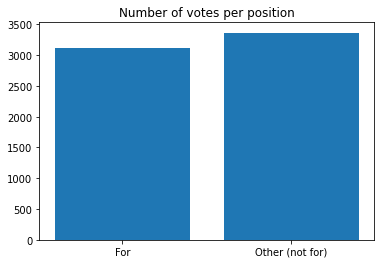

In [8]:
votes_for = y.sum()
votes_other = y.shape[0] - votes_for

plt.bar([1, 2], [votes_for.sum(), votes_other.sum()])
plt.xticks([1, 2], ('For', 'Other (not for)'))
plt.title("Number of votes per position")
plt.show()

But if we do a breakdown per party, the story is not the same. "LaRem" (La République En Marche) and "Dem" (Démocrates et apparentés) almost never votes for. And the left leaning groups (SOC Socialistes, FI France Insoumise, GDR Gauche Démocrate et Républiquaine) very often vote for, despite being a minority in the Assembly. 

The intuition we get is that left-leaning parties propose a lot of amendments that the majority parites (La République En Marche and Démocrates et appartentés) systematically block. This kind of "useless amendments", that you know will be blocked but that you propose nonetheless just to delay the proposition of law, can be apparented to [Filibuster](https://en.wikipedia.org/wiki/Filibuster) (*obstruction parlementaire*). This is, however, still an intuition.

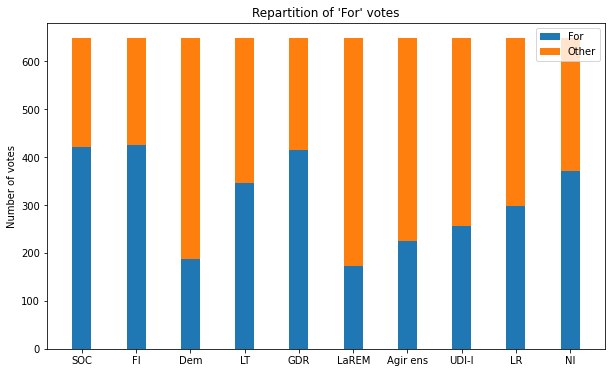

In [9]:
ind = np.arange(len(y.columns))

plt.figure(figsize=(10,6))

p1 = plt.bar(ind, votes_for, width=0.35)
p2 = plt.bar(ind, votes_other, width=0.35, bottom=votes_for)


plt.ylabel('Number of votes')
plt.title('Repartition of \'For\' votes')
plt.xticks(ind, y.columns)
plt.legend((p1[0], p2[0]), ("For", 'Other'))

plt.show()

#### Vote demandeur repartition

Let's now look at the most common demandeur. To clean up demandeur's column, we use a custom Transformer available in `estimator.py`.

We see that the group La France Insoumise, despite having 17 deputies in the Assemblée, is the leading demandeur. This means that most amendments are proposed by this minority group. This confirm our analysis: Government's opposition is Filibusting, by asking very often to vote texts that have no chance to pass. 

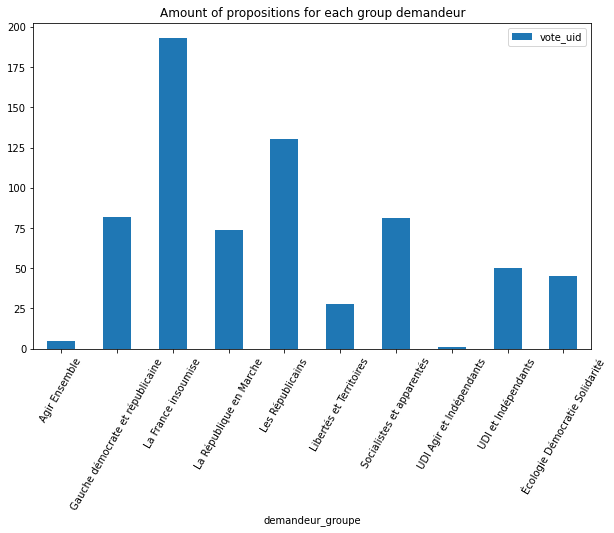

In [10]:
from estimator import FindGroupVoteDemandeurTransformer
from ast import literal_eval

demandeur = FindGroupVoteDemandeurTransformer()
X_b = demandeur.transform(X.copy())
# Won't explode without this trick
X_b['demandeur_groupe'] = X_b['demandeur_groupe'].apply(literal_eval)
X_b = X_b[["demandeur_groupe", "vote_uid"]].explode('demandeur_groupe', ignore_index=True)
demandeur_table = X_b.groupby("demandeur_groupe").count()

# Plot
demandeur_table.plot(kind='bar', figsize=(10,6))
plt.title("Amount of propositions for each group demandeur")
plt.xticks(rotation=60)
plt.show()

Now, let's cross this information with the voting groups, to see which group vote most for which group's proposals. To do that, we compute some kind of confusion matrix that indicates the share of times a voting group voted for this demandeur group. 

In [32]:
map_group_sigle = {'Agir Ensemble': 'Agir ens', 
'Gauche démocrate et républicaine': 'GDR',
'La France insoumise': 'FI',
'La République en Marche': 'LaREM',
'Les Républicains': 'LR',
'Libertés et Territoires': 'LT',
'Socialistes et apparentés': 'SOC',
'UDI Agir et Indépendants': 'UDI Agir I',
'UDI et Indépendants': 'UDI-I',
'Écologie Démocratie Solidarité': 'Eco',
'Non inscrits': 'NI',
np.nan: 'UNK'}

X_b['demandeur_groupe_sigle'] = X_b['demandeur_groupe'].apply(lambda x: map_group_sigle[x])

partisanship_table = X_b.set_index('vote_uid').join(y).groupby('demandeur_groupe_sigle').sum()
opposition_table =  X_b.set_index('vote_uid').join(1 - y).groupby('demandeur_groupe_sigle').sum()

# Normalize by the number of votes
partisanship_table_norm = partisanship_table / (partisanship_table + opposition_table)
partisanship_table_norm.sort_index(axis=1, inplace=True)

partisanship_table_norm

,Agir ens,Dem,FI,GDR,LR,LT,LaREM,NI,SOC,UDI-I
demandeur_groupe_sigle,,,,,,,,,,
Agir ens,0.800000,0.400000,0.200000,0.600000,0.600000,0.600000,0.200000,0.800000,0.200000,0.600000
Eco,0.244444,0.111111,0.822222,0.800000,0.377778,0.733333,0.066667,0.955556,0.711111,0.200000
FI,0.150259,0.181347,0.813472,0.715026,0.186528,0.352332,0.181347,0.331606,0.668394,0.181347
GDR,0.268293,0.170732,0.853659,0.853659,0.353659,0.609756,0.170732,0.512195,0.817073,0.280488
LR,0.361538,0.215385,0.476923,0.500000,0.853846,0.561538,0.200000,0.769231,0.546154,0.630769
LT,0.464286,0.321429,0.642857,0.642857,0.535714,0.750000,0.250000,0.571429,0.642857,0.392857
LaREM,0.878378,0.918919,0.229730,0.270270,0.513514,0.432432,0.932432,0.608108,0.378378,0.648649
SOC,0.271605,0.185185,0.802469,0.790123,0.432099,0.691358,0.135802,0.629630,0.864198,0.283951
UDI Agir I,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000


Since numbers between 0 and 1 are hard to read, we also plot the results below. Red squares mean the two groups disagree, blue squares means the two groups agree. 

Note here that we have some missing data, labeled UNK, which corresponds most likely to proposals by the Government.

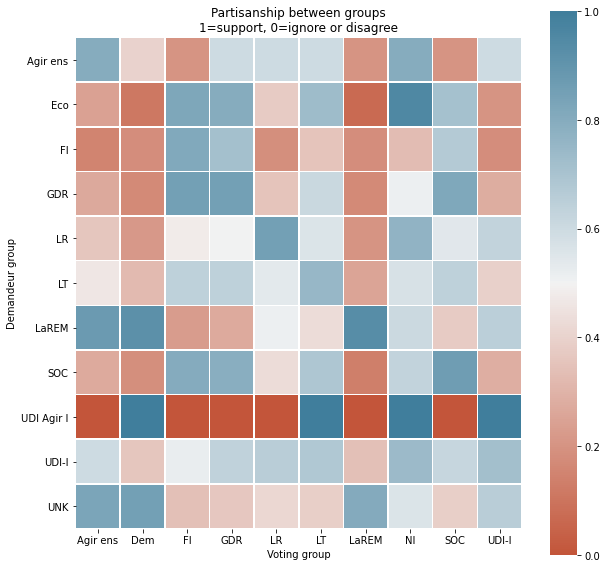

In [33]:
cmap = sns.diverging_palette(20, 230, as_cmap=True)

plt.figure(figsize=(10,10))
sns.heatmap(partisanship_table_norm.sort_index(axis=1), cmap=cmap, center=0.5, square=True, linewidths=.5,)
plt.ylabel('Demandeur group')
plt.xlabel('Voting group')
plt.title('Partisanship between groups\n1=support, 0=ignore or disagree')
# plt.xticks(rotation=60)
plt.show()

Now, the story is pretty clear. LaREM (La République En Marche) only agrees with proposals from their own members. 

In general, if the voting and the demandeur groups are the same, there is support. This is logical: groups vote for their own amendments. However, it's interesting to note when the intra-group support is low. This is the case for FI (France Insoumise) and UDI-I (UDI Indépendants). It might be the sign of idelogical tensions inside the group.

LaREM is often criticized for becomming more and more right-leaning on the political spectrum. This is because Macron appointed as ministers many politicians from LR. But, on this chart, we see that LaREM (center right)and LR (traditional right) agree mostly on voting against FI, GDR, and SOC proposals. Indeed, LR support LaREM on a bit over half of theirs proposals, and LaREM support less than half of LR proposals. What seems to be an alliance from the outside, is much less so inside the Assembly. 

This chart also reveals ideological contradictions between public relations and votes. Notably, LaREM rarely votes for Eco (Ecologistes), despite environment being one of the main campaign points of Emmanuel Macron. 

The proposals from UDI Agir-I (UDI Agir et Indépendants) are notably cleaving. It's probably an outlier, and values are extreme due to small number of votes involving this group.  



## Example model 

To elaborate the perdictions, we created an estimator.py file that does some transformations on the data received from the problem.py.

### Find the groups that propose a vote
First, we extract the parties that are proposing a vote. There is often more than one group that submits a proposition. By having a look at the dataset, we extracted the different groups. We return a list so we can have multiple parties.

### Decompose the "vote_objet" column
The "vote_objet" column contains 3 main pieces of information :
- What kind of vote has been voted (a law, an amendement ...)
- A short description of the vote
- The authors of the proposition

We wrote 3 functions that we apply to the "vote_objet" column in order to have these information by the use of regex expressions


### Find the party of each author of a proposition
From the previous transformer we had authors for a vote, now we are focusing on finding their party

### The estimator
*Actors*

We fetch some other data about the deputies in order to have some information about them and their parties. We use fill the missing value with a constant field 'unknown'.

*Count vectorizer*

We wanted to make use of the description of the proposition, indeed some words may be left or right wing connoted. To use these words, we first instanciate a CountVectorizer. It counts the occurency of words in a corpus based on a pre-defined vocabulary set. The matrix returned is the size (number of sentences, size of the vocabulary list). The ith element in a line is the count of the occurency of the ith vocabulary word. In our case the vocabulary set if all the words found in the description of the propositions.

*TF-IDF transformer*

We proceed with a TF-IDF transformer on our count vector. Sklearn's doc describes it as follows :
>Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency. This is a common term weighting scheme in information retrieval, that has also found good use in document classification.

>The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

*https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html*

We assign some weights to the important words by weighting more the name of a law (*bioéthique* or *sécurité globale* for instance)

In [ ]:
# %%
model = get_estimator()

# %%
#X_train, y_train = get_train_data()
#X_test, y_test = get_test_data()

# %%
from sklearn.utils import class_weight

weights = np.mean(np.sum(y_train, axis=0))/np.sum(y_train, axis=0)
dict_weights = dict(enumerate(weights))

# %%

model.fit(X_train, y_train.to_numpy(), 
    nn__batch_size=4096, 
    nn__epochs=500, 
    nn__class_weight=dict_weights,
    nn__verbose=0)
model.score(X_test, y_test.to_numpy())
# %%
from sklearn.metrics import multilabel_confusion_matrix

y_pred = 1*(model.predict_proba(X_test) > 0.5)
confusion_matrix = multilabel_confusion_matrix(y_test.to_numpy(), y_pred)
for i in range(10):
    print("Confusion matrix for", y_test.columns[i])
    print(confusion_matrix[i])
